<div align="center">

<img src="../logo_isel.png" alt="ISEL" width="400"/>

<br><br>

**Instituto Superior de Engenharia de Lisboa**  
Licenciatura em Engenharia Informática e Multimédia  

<br><br>

### <u>Processamento de Imagem e Visão (PIV)</u>  
**Semestre de Inverno 25/26**

<br>

## 1º Trabalho Prático
**Contagem e Classificação de Peças LEGO**

<br><br><br>

<div align="left">

**Trabalho realizado por:**  
Miguel Cordeiro — nº 40765 — LEIM51N Grupo x  
Bruno Santos — nº 45096 — LEIM51N Grupo x  

**Docente:** Eng.º x 

</div>

</div>


### 1. Introdução

<div style="text-align: justify">
Neste trabalho, pretende-se desenvolver um algoritmo que seja capaz de contar um conjunto de ***peças de lego retangulares*** que foram colocadas em cima de uma mesa. Esta contagem não pode ser feita através da cor e o algoritmo é desenvolvido através da biblioteca de funções *OpenCV*, uma biblioteca usada na programação de aplicações de visão em tempo real para a linguagem de programação ***Python***.

Este algoritmo conta as peças com base nas suas dimensões. As dimensões a serem consideradas são ***2x2***, ***2x4***, ***2x6*** e ***2x8***. Qualquer outra peça que não se enquadre nestes formatos ou cujo o formato não seja perceptivel mesmo após o processamento das imagens e aplicação do algoritmo será considerada como ***Indefinido***.

Além da contagem de peças, o algoritmo irá tratar devidamente algumas perturbações que possam alterar as contagens, nomeadamente sombras, outras peças de lego no campo de visão e o contacto entre peças de lego.

**Conceitos Teóricos**

> Limiar Local: O limiar local é o valor de corte calculado para cada zona da imagem, em vez de um único valor global.

> Histograma de Imagens: É uma representação gráfica que mostra a distribuição de intensidades dos pixeis de uma imagem. Esta representação gráfica é fundamental na análise de uma imagem pois permite visualizar o número de pixeis por nível de brilho, do mais escuro para o mais claro.

> Binarização: A Binarização é um processo no qual se transforma uma imagem colorida ou em tons de cinza numa imagem binária, isto é, uma imagem representada apenas por duas cores: Preto e Branco.
> Este processo envolve a aplicação de um threshold, que determina os pixeis da imagem original serão convertidos para pretos e os que são convertidos para branco.
> Um caso particular sobre os tipos de métodos de Binarização é a Binarização Adaptativa, que foi o método adotado neste trabalho. Este método é especialmente útil em imagens com iluminação não uniforme porque permite preservar os detalhes em áreas com os mais variados contrastes.
> Uma das vantagens da Binarização é a redução da complexidade dos dados. Ao converter uma imagem em formato binário, os algoritmos de análise e processamento podem operar de forma mais eficiente, isto enquanto poupa tempo e recursos computacionais.

</div>

    - Bibliotecas Importadas

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 2. Leitura de Imagens

(530, 706, 3)
(530, 706)


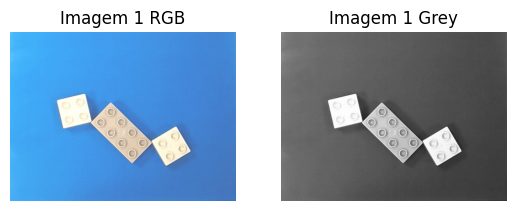

In [53]:
# Variavel de path [MUDAR PATH PARA TESTAR COM OUTRA IMAGEM]
path_img1 = "../images/lego04.jpg"
path_img2 = "../images/lego10.jpg"
path_img3 = "../images/lego11.jpg"
path_img4 = "../images/lego13.jpg"
path_img5 = "../images/lego32.jpg"

# Ler imagens
img1 = cv2.imread(path_img1)
img2 = cv2.imread(path_img2)
img3 = cv2.imread(path_img3)
img4 = cv2.imread(path_img4)
img5 = cv2.imread(path_img5)



# Converter para RGB
img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img_rgb4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img_rgb5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

# Passar Imagem para Tons de Cinzento
img_gray1 = cv2.imread(path_img1, cv2.IMREAD_GRAYSCALE)
img_gray2 = cv2.imread(path_img2, cv2.IMREAD_GRAYSCALE)
img_gray3 = cv2.imread(path_img3, cv2.IMREAD_GRAYSCALE)
img_gray4 = cv2.imread(path_img4, cv2.IMREAD_GRAYSCALE)
img_gray5 = cv2.imread(path_img5, cv2.IMREAD_GRAYSCALE)

# Canais de cores = 3
print(np.shape(img1))
print(np.shape(img_gray1))

# Mostrar imagem RGB
plt.subplot(1,2,1)
plt.imshow(img_rgb1)
plt.title("Imagem 1 RGB")
plt.axis("off")



# Mostrar imagem Grey
plt.subplot(1,2,2)
plt.imshow(img_gray1, cmap="gray")
plt.title("Imagem 1 Grey")
plt.axis("off")
plt.show()

Antes de passarmos para a binarização decidi separar a imagem nos 3 canais de cor (R, G, B).

Ao analisar o histograma, concluímos que o canal vermelho apresenta a melhor separação de intensidades entre o fundo e as peças, o que facilita a aplicação de um threshold para isolar as peças da mesa.

Nesta etapa do projeto, chegamos então à conclusão, a partir do histograma com os canais de cor que o valor de Thrashold que iremos usar seria 110.

Em termos, neste canal de cor (Vermelho), o fundo representaria a aproximação da ausencia de cor (valor 0) e as peças a aproximação da cor vermelha (valor 255).

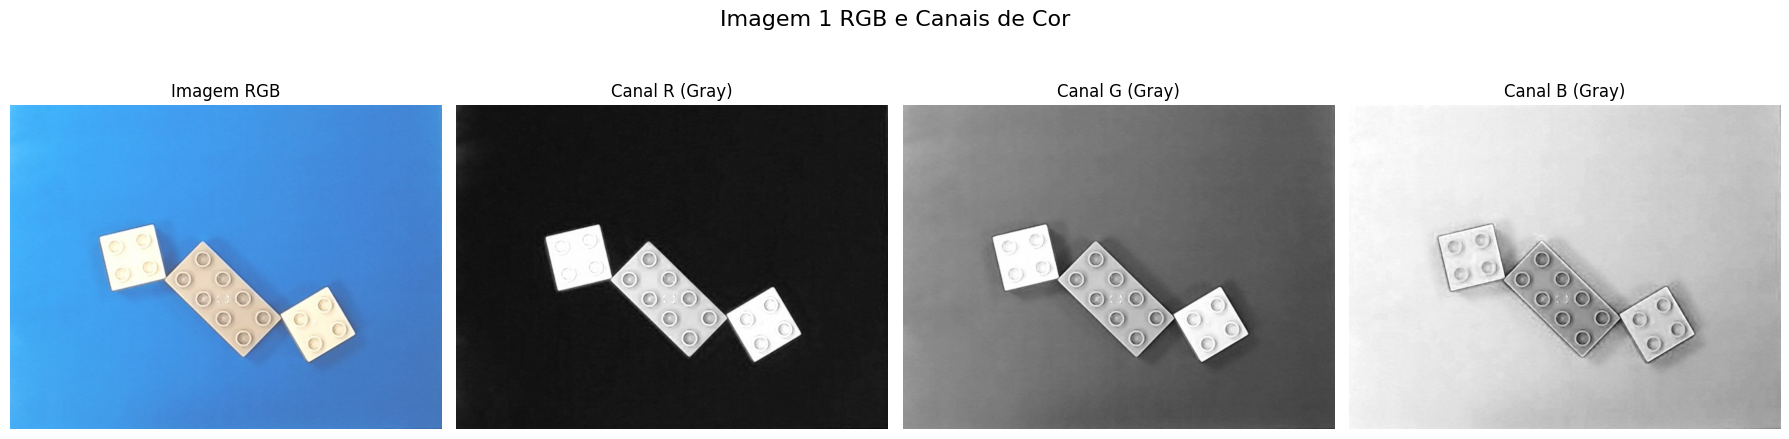

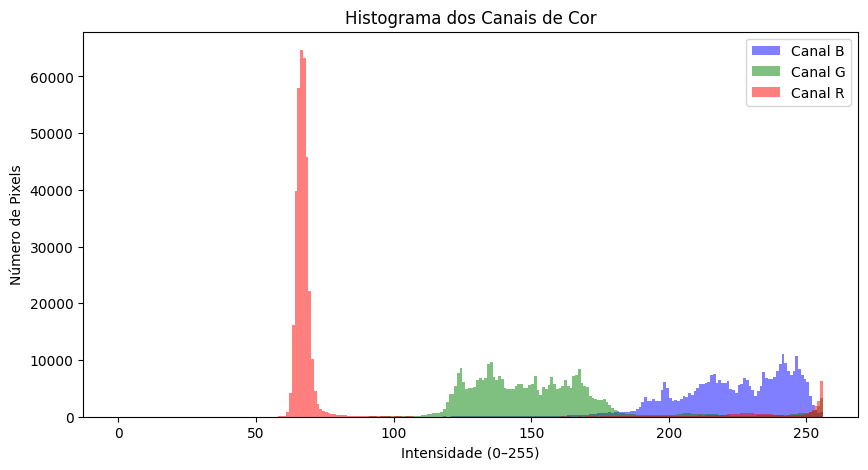

In [54]:
# Separa canais já em RGB (ordem: R, G, B)
r1, g1, b1 = cv2.split(img_rgb1)
zeros1 = np.zeros_like(r1)

# Constrói imagens dos canais em RGB
#img_red1 = np.dstack([r1, zeros1, zeros1])
#img_green1 = np.dstack([zeros1, g1, zeros1])
#img_blue1  = np.dstack([zeros1, zeros1, b1])

# Converter cada uma para tons de cinzento
#gray_red1 = cv2.cvtColor(img_red1, cv2.COLOR_RGB2GRAY)
#gray_green1 = cv2.cvtColor(img_green1, cv2.COLOR_RGB2GRAY)
#gray_blue1  = cv2.cvtColor(img_blue1, cv2.COLOR_RGB2GRAY)

# cria uma cópia independente dos valores do canal, preservando as intensidades originais (0–255) sem alterar ou reescalar a imagem
gray_red1 = r1.copy()
gray_green1 = g1.copy()
gray_blue1 = b1.copy()

# ___________________Canais de Cor PLOT___________________

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle("Imagem 1 RGB e Canais de Cor", fontsize=16)

# Imagem original
axes[0].imshow(img_rgb1)
axes[0].set_title("Imagem RGB")
axes[0].axis("off")

# Canal R
axes[1].imshow(gray_red1, cmap='gray')
axes[1].set_title("Canal R (Gray)")
axes[1].axis("off")

# Canal G
axes[2].imshow(gray_green1, cmap='gray')
axes[2].set_title("Canal G (Gray)")
axes[2].axis("off")

# Canal B
axes[3].imshow(gray_blue1, cmap='gray')
axes[3].set_title("Canal B (Gray)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

# ___________________HISTOGRAMA PLOT___________________
plt.figure(figsize=(10,5))
plt.title("Histograma dos Canais de Cor")
plt.xlabel("Intensidade (0–255)")
plt.ylabel("Número de Pixels")

plt.hist(b1.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.5, label='Canal B')
plt.hist(g1.ravel(), bins=256, range=[0, 256], color='green', alpha=0.5, label='Canal G')
plt.hist(r1.ravel(), bins=256, range=[0, 256], color='red', alpha=0.5, label='Canal R')

plt.legend()
plt.show()

Célula Adicional para contruir os canais de cor das restantes imagens

In [59]:
# Separa canais já em RGB (ordem: R, G, B)
r2, g2, b2 = cv2.split(img_rgb2)
r3, g3, b3 = cv2.split(img_rgb3)
r4, g4, b4 = cv2.split(img_rgb4)
r5, g5, b5 = cv2.split(img_rgb5)

zeros2 = np.zeros_like(r2)
zeros3 = np.zeros_like(r3)
zeros4 = np.zeros_like(r4)
zeros5 = np.zeros_like(r5)

# Constrói imagens dos canais em RGB
# img_red2   = np.dstack([r2, zeros2, zeros2])
# img_green2 = np.dstack([zeros2, g2, zeros2])
# img_blue2  = np.dstack([zeros2, zeros2, b2])
# img_red3   = np.dstack([r3, zeros3, zeros3])
# img_green3 = np.dstack([zeros3, g3, zeros3])
# img_blue3  = np.dstack([zeros3, zeros3, b3])
# img_red4   = np.dstack([r4, zeros4, zeros4])
# img_green4 = np.dstack([zeros4, g4, zeros4])
# img_blue4  = np.dstack([zeros4, zeros4, b4])
# img_red5   = np.dstack([r5, zeros5, zeros5])
# img_green5 = np.dstack([zeros5, g5, zeros5])
# img_blue5  = np.dstack([zeros5, zeros5, b5])

# Converter cada uma para tons de cinzento
# gray_red2   = cv2.cvtColor(img_red2, cv2.COLOR_RGB2GRAY)
# gray_green2 = cv2.cvtColor(img_green2, cv2.COLOR_RGB2GRAY)
# gray_blue2  = cv2.cvtColor(img_blue2, cv2.COLOR_RGB2GRAY)
# gray_red3   = cv2.cvtColor(img_red3, cv2.COLOR_RGB2GRAY)
# gray_green3 = cv2.cvtColor(img_green3, cv2.COLOR_RGB2GRAY)
# gray_blue3  = cv2.cvtColor(img_blue3, cv2.COLOR_RGB2GRAY)
# gray_red4   = cv2.cvtColor(img_red4, cv2.COLOR_RGB2GRAY)
# gray_green4 = cv2.cvtColor(img_green4, cv2.COLOR_RGB2GRAY)
# gray_blue4  = cv2.cvtColor(img_blue4, cv2.COLOR_RGB2GRAY)
# gray_red5   = cv2.cvtColor(img_red5, cv2.COLOR_RGB2GRAY)
# gray_green5 = cv2.cvtColor(img_green5, cv2.COLOR_RGB2GRAY)
# gray_blue5  = cv2.cvtColor(img_blue5, cv2.COLOR_RGB2GRAY)

gray_red2 = r2.copy()
gray_green2 = g2.copy()
gray_blue2 = b2.copy()
gray_red3 = r3.copy()
gray_green3 = r3.copy()
gray_blue3 = b3.copy()
gray_red4 = r4.copy()
gray_green4 = g4.copy()
gray_blue4 = b4.copy()
gray_red5 = r5.copy()
gray_green5 = g5.copy()
gray_blue5 = b5.copy()

### 3. Binarização

Começamos o processo de binarização antes de descobrir a melhor forma de analisar a imagem e a separação de canais de cor (R, G, B) antes de passar para este processo. Deste modo, dividimos esta secção em duas tentativas, sendo a segunda a correta, com o melhor resultado de Binarização.

    - Primeira Tentativa

Usamos um filtro GaussianBlur para reduzir o ruido [TO:DO]

In [56]:
# Suavizar ligeiramente para reduzir ruído
img_blur_1t = cv2.GaussianBlur(gray_red1, (5, 5), 0)

Para binarização precisavamos usar um Threshold para converter a imagem (cinzento com o filtro Gaussian aplicado) em uma imagem binária.

Em vez de um Threshold Simples (dado em aula), optamos por usar um threshold adaptativo porque embora todas as imagens terem um background de uma so cor definida este adapta-se melhor a variações de luz local e lida bem com sombras.

Parametros:
- blockSize: Tamanho da vizinhança.
    - Testamos vários valores para o tamanho da vizinhança para conseguirmos obter o melhor resultado de binarização, embora sempre valores impares (com objetivo de existir sempre um centro para o pixel a ser analisado).
- C: Ajusta a agressividade do filtro.



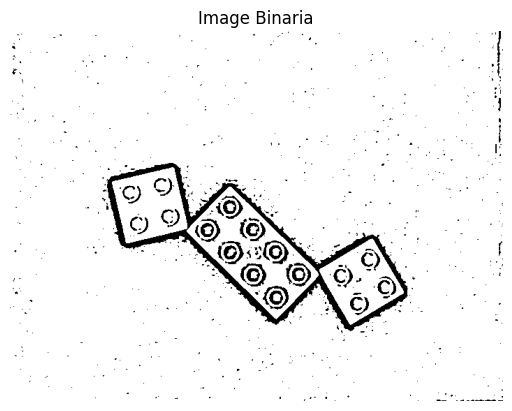

In [57]:
# Threshold adaptativo
blockSize = 15 # blockSize: tamanho da vizinhança (impar)
C = 2 # agressividade do filtro
adaptativeThreshold = cv2.adaptiveThreshold(img_blur_1t, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C)

# Mostrar imagem
plt.imshow(adaptativeThreshold, cmap="gray")
plt.title("Image Binaria")
plt.axis("off")  # Remove os eixos
plt.show()

Como já brevemente referido no Markdown em cima, esta tentativa foi realizada com o canal de cor simples em Gray apenas. Complicamos o processo para chegar ao resultado mais esperado e depois chegamos à conclusão que, a partir da separação em canais de cor (R, G, B) conseguiriamos obter o melhor resultado mesmo antes de efetuarmos filtros e binarização.

    - Segunda Tentativa

Nesta segunda tentativa, a correta, começamos por aplicar um filtro do tipo GaussianBlur com o objetivo de suavizar o ruído presente na imagem.

Este filtro realiza uma média ponderada das intensidades dos pixels vizinhos, reduzindo variações abruptas causadas por iluminação ou pequenas imperfeições no fundo, o que facilita a etapa de binarização.

De seguida, aplicamos um Threshold (Binarização) com o valor a 85, retirado no histograma dos canais de cor e conseguimos obter um resultado muito perto do resultado esperado. Este valor permite então criar um barreira entre o que são valores 1 (Cor) e o que são valores 0 (Ausencia de Cor), separando assim por completo as peças do fundo.

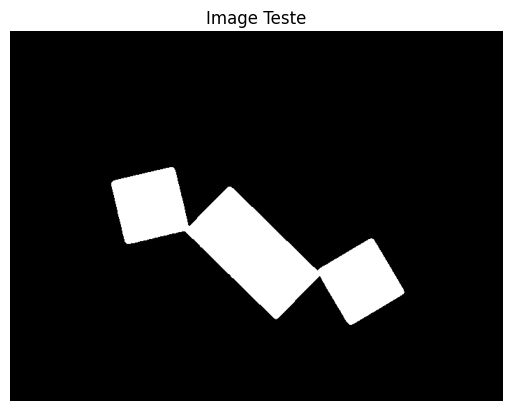

In [68]:
# Suavizar ruído
gr_blur1 = cv2.GaussianBlur(gray_red1, (5, 5), 0)

T1, bw1 = cv2.threshold(gr_blur1, 110, 255, cv2.THRESH_BINARY)

plt.imshow(bw1, cmap="gray")
plt.title("Image Teste")
plt.axis("off")  # Remove os eixos
plt.show()


Binarização para os casos mais criticos

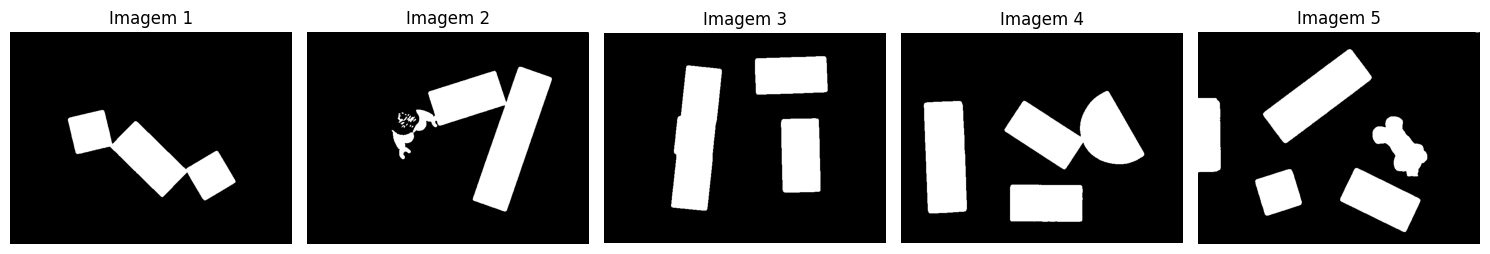

In [69]:
gr_blur2 = cv2.GaussianBlur(gray_red2, (5, 5), 0)
gr_blur3 = cv2.GaussianBlur(gray_red3, (5, 5), 0)
gr_blur4 = cv2.GaussianBlur(gray_red4, (5, 5), 0)
gr_blur5 = cv2.GaussianBlur(gray_red5, (5, 5), 0)

T2, bw2 = cv2.threshold(gr_blur2, 110, 255, cv2.THRESH_BINARY)
T3, bw3 = cv2.threshold(gr_blur3, 110, 255, cv2.THRESH_BINARY)
T4, bw4 = cv2.threshold(gr_blur4, 110, 255, cv2.THRESH_BINARY)
T5, bw5 = cv2.threshold(gr_blur5, 110, 255, cv2.THRESH_BINARY)

# PLOTS

bws = [bw1, bw2, bw3, bw4, bw5]
titulos = ["Imagem 1", "Imagem 2", "Imagem 3", "Imagem 4", "Imagem 5"]

plt.figure(figsize=(15, 5))  # largura x altura

for i in range(5):
    plt.subplot(1, 5, i+1)       # 1 linha, 5 colunas
    plt.imshow(bws[i], cmap="gray")
    plt.title(titulos[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

Com estes novos plots das binarizações em casos mais criticos, estes escolhidos por nós, conseguimos tirar a conclusão de a existência de um novo problema. Existem peças que tocam umas nas outras, dificultando assim o processo de separação de objetos.

Para retirar esse efeito vamos usar duas funções:

erode - aumentar a imagem

delaite - arredondar os cantos

FONTES:

https://kfcdicasdigital.com/glossario/o-que-e-binarizacao-de-imagem/

https://clubedogis.com.br/glossario/o-que-e-histogramas-de-imagens-guia-completo/